# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib

from matplotlib import rcParams
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb

import seaborn as sns
from scipy.stats import mode

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках

In [5]:
%config InlineBackend.figure_format = 'svg'  # оптимизация изображения графиков

In [6]:
rcParams.update({'font.size': 14}) #размер шрифта графиков - 14

# Описание признаков

In [7]:
#Id - идентификационный номер квартиры
#DistrictId - идентификационный номер района
#Rooms - количество комнат
#Square - площадь
#LifeSquare - жилая площадь
#KitchenSquare - площадь кухни
#Floor - этаж
#HouseFloor - количество этажей в доме
#HouseYear - год постройки дома
#Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
#Social_1, Social_2, Social_3 - социальные показатели местности
#Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
#Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
#Price - цена квартиры

# Пути к файлам

In [8]:
SAMPLE_SUBMISSIN_PATH = 'c:/Users/nikif/jupiter files/Numpy Pandas Matplotlib Scikit-learn/Kursovik/sample_submission.csv'
TEST_PATH = 'c:/Users/nikif/jupiter files/Numpy Pandas Matplotlib Scikit-learn/Kursovik/test.csv'
TRAIN_PATH = 'c:/Users/nikif/jupiter files/Numpy Pandas Matplotlib Scikit-learn/Kursovik/train.csv'

# Извлечение данных

In [9]:
df1 = pd.read_csv('sample_submission.csv')
test_predata = pd.read_csv('test.csv')
train_predata = pd.read_csv('train.csv')

# Создание класса

In [10]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.Rooms = None
        self.Square = None
        self.LifeSquare = None
        self.KitchenSquare = None
        self.HouseFloor = None
        self.Social_2 = None
        self.Social_3 = None
        self.Healthcare_1 = None
        self.pricebydistrict = None
        self.pricebyflooryear = None
        self.pricebydistrict_median = None
        self.pricebyflooryear_median = None
        self.districts_healthcare = None
        self.district_price_per_square = None
        self.LifeSquare_k = None 
        self.KitchenSquare_k = None
        
    def stat(self, df):
        """Сохранение статистик"""
        # Расчет медиан
        self.medians = df[['LifeSquare', 'Healthcare_1']].median()
        self.Rooms = df['Rooms'].median()
        self.Square = df['Square'].median()
        self.LifeSquare = df['LifeSquare'].median()
        self.KitchenSquare = df['KitchenSquare'].median()
        self.HouseFloor = df['HouseFloor'].median()
        self.Social_2 = df['Social_2'].median()
        self.Social_3 = df['Social_3'].median()
        self.Healthcare_1 = df['Healthcare_1'].median()
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') / df.groupby(['DistrictId'])['Square'].agg('median')
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('median').fillna(df['Healthcare_1'].median()).to_dict()        
        
    """Подготовка данный для трейна"""    
    def transform_train(self, df):
        """Трансформация данных"""
        
        # 1. Создание новых признаков с пропусками  
        df['Healthcare_1_NAN'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_NAN'] = 1
        df['LifeSquare_NAN'] = 0
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_NAN'] = 1
        df['KitchenSquare_1'] = 0
        df.loc[df['KitchenSquare'] == 1, 'KitchenSquare_1'] = 1
        
        # 2. Выбросы (outliers)
        #clevercutfeature
        df.loc[df['Rooms'] > 7, 'Rooms'] = df['Rooms'].median() #7
        df.loc[(df['Square'] > 145) | (df['Square'] < 10), 'Square'] = df['Square'].median()  # 145 - 10
        df.loc[(df['LifeSquare'] > 200) | (df['LifeSquare'] < 10), 'LifeSquare'] = df['LifeSquare'].median() #++
        df.loc[(df['KitchenSquare'] > 15) | (df['KitchenSquare'] < 3), 'KitchenSquare'] = df['KitchenSquare'].median() #15 -3
        df.loc[df['HouseFloor'] > 60, 'HouseFloor'] = df['HouseFloor'].median()
        df.loc[df['HouseYear'] > 2022, 'HouseYear'] = 2022
        df.loc[df['Social_2'] > 17500, 'Social_2'] = df['Social_2'].median()
        df.loc[df['Social_3'] > 100, 'Social_3'] = df['Social_3'].median()
        df.loc[df['Healthcare_1'] < 50, 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df.loc[df.index[[2194, 3780, 5894, 6088]], 'Rooms'] = 1
        df.loc[df.index[[7644, 9869, 8794, 2004, 2728]], 'Rooms'] = 2
        df.loc[df.index[[6401, 8794]], 'Rooms'] = 3
        df.loc[df.index[7929], 'Rooms'] = 4
        df.loc[df.index[9767], 'Rooms'] = 5
        
        # Square
        # Замена переменных местами, где Square < LifeSquare
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))
        
        #Floor
        # Замена переменных местами, где HouseFloor < Floor
        df['Floor'], df['HouseFloor'] = np.where(df['Floor'] < df['HouseFloor'], (df['Floor'], df['HouseFloor']), (df['HouseFloor'], df['Floor']))
                
        # 2. Заполнение пропусков     
        #LifeSquare_fillna_median
        for i in df.loc[df.LifeSquare.isna() == True, 'LifeSquare'].index:
            df.LifeSquare[i] = (df.Square[i] - df.KitchenSquare[i]) - df.Square[i]*0.2 #++
                        
        #Healthcare_1_fillna - заполнение пропусков Healthcare_1
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)    
        
        #Заполнение нулевых этажей
        df.loc[df['Floor'] == 0, 'Floor'] = df['Floor'].median()
        
        #LifeSquare_Normalise - нормализация значений LifeSquare в случае превышения суммы KitchenSquare и LifeSquare значений Square
        for i in df.loc[df.Square < df.KitchenSquare + df.LifeSquare].index:
            df.LifeSquare[i] = (df.Square[i] - df.KitchenSquare[i]) - df.Square[i]*0.2 #+
            
        # 3. Новые фичи (features):
        # Обработка количественных переменных
        # Площадь на одну комнату
        df['Square/Rooms'] = df['Square'] / df['Rooms']
        # Доля жилой площади
        df['LifeSquare_percent'] = df['LifeSquare'] / df['Square'] * 100
        # Доля площади кухни
        df['KitchenSquare_percent'] = df['KitchenSquare'] / df['Square'] * 100
        #DistrictSize
        district_size = df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        df = df.merge(district_size, on='DistrictId', how='left')
        #DistrictLarge
        df['DistrictLarge'] = (df['DistrictSize'] > 100).astype(int)        
        
        #Разбиени по группам
        #Этажи
        df['floor_cat'] = 0
        df.loc[df['Floor'] <= 3, 'floor_cat'] = 1  
        df.loc[(df['Floor'] > 3) & (df['Floor'] <= 5), 'floor_cat'] = 2
        df.loc[(df['Floor'] > 5) & (df['Floor'] <= 9), 'floor_cat'] = 3
        df.loc[(df['Floor'] > 9) & (df['Floor'] <= 15), 'floor_cat'] = 4
        df.loc[df['Floor'] > 15, 'floor_cat'] = 5
        
        #Год постройки
        df['year_cat'] = 0
        df.loc[df['HouseYear'] <= 1941, 'year_cat'] = 1
        df.loc[(df['HouseYear'] > 1941) & (df['HouseYear'] <= 1945), 'year_cat'] = 2
        df.loc[(df['HouseYear'] > 1945) & (df['HouseYear'] <= 1980), 'year_cat'] = 3
        df.loc[(df['HouseYear'] > 1980) & (df['HouseYear'] <= 2000), 'year_cat'] = 4
        df.loc[(df['HouseYear'] > 2000) & (df['HouseYear'] <= 2010), 'year_cat'] = 5
        df.loc[(df['HouseYear'] > 2010), 'year_cat'] = 6  
        
        #LifeSquare_Square_cut_median
        square_bins = [0, 20, 40, 60, 80, 100, 120, 160, 180]
        df['Square_cat'] = (pd.cut(df.Square, bins=square_bins, labels=[20, 40, 60, 80, 100, 120, 160, 180])).astype(int)
        df = df.merge(pd.DataFrame(df.groupby('Square_cat')['LifeSquare'].agg('median')), on=['Square_cat'], how='left')\
        .rename(columns={'LifeSquare_x': 'LifeSquare', 'LifeSquare_y': 'LifeSquare_Square_cut_median'})
        
        #gropby 
        #PriceByDistrict - среднняя цена, сгрупиррованая по районам и комнатам
        self.pricebydistrict = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'PriceByDistrict'})
        df = df.merge(self.pricebydistrict, on=['DistrictId', 'Rooms'], how='left')   
        #PriceByFloorYear - среднняя цена, сгрупиррованая по бинам года постройки и этажа.
        self.pricebyflooryear = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price':'PriceByFloorYear'})
        df = df.merge(self.pricebyflooryear, on=['year_cat', 'floor_cat'], how='left')
        #District_price_per_square - отношение цены по району к цене по площади.
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        #Districts_healthcare - уровень здравоохранения по району.
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)
        
        self.pricebydistrict_median = self.pricebydistrict.median()
        self.pricebyflooryear_median = self.pricebyflooryear.median()
        
        # Обработка категориальных признаков
        df = pd.concat([df, pd.get_dummies(df[['Shops_2', 'Ecology_2', 'Ecology_3']],\
                                           prefix=['Shops_2', 'Ecology_2', 'Ecology_3'])], axis=1)
        # 5. Удаление ненужных признаков
        df = df.drop(columns=['Id', 'Shops_2', 'Ecology_2', 'Ecology_3'], axis=1)     
        
        return df
        
    """Подготовка данных для теста"""
    def transform_test(self, df):
        """Трансформация данных"""
        # 1. Создание новых признаков с пропусками  
        df['Healthcare_1_NAN'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_NAN'] = 1
        df['LifeSquare_NAN'] = 0
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_NAN'] = 1
        df['KitchenSquare_1'] = 0
        df.loc[df['KitchenSquare'] == 1, 'KitchenSquare_1'] = 1
        
        # 2. Выбросы (outliers)
        #clevercutfeature
        df.loc[df['Rooms'] > 5, 'Rooms'] = self.Rooms
        df.loc[(df['Square'] > 200) | (df['Square'] < 10), 'Square'] = self.Square
        df.loc[(df['LifeSquare'] > 150) | (df['LifeSquare'] < 10), 'LifeSquare'] = self.LifeSquare
        df.loc[(df['KitchenSquare'] > 15) | (df['KitchenSquare'] < 3), 'KitchenSquare'] = self.KitchenSquare
        df.loc[df['HouseFloor'] > 60, 'HouseFloor'] = self.HouseFloor
        df.loc[df['HouseYear'] > 2022, 'HouseYear'] = 2022
        df.loc[df['Social_2'] > 17500, 'Social_2'] = self.Social_2
        df.loc[df['Social_3'] > 100, 'Social_3'] = self.Social_3
        df.loc[df['Healthcare_1'] < 50, 'Healthcare_1'] = df['Healthcare_1'].median()
        df.loc[df.index[961], 'Rooms'] = 4
        df.loc[df.index[4179], 'Rooms'] = 3
        
        # 2. Заполнение пропусков     
        #LifeSquare_fillna_median
        for i in df.loc[df.LifeSquare.isna() == True, 'LifeSquare'].index:
            df.LifeSquare[i] = (df.Square[i] - df.KitchenSquare[i]) - df.Square[i]*0.2
        
        #Healthcare_1 fillna
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('median').to_dict()
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True) 
        
        # 3. Новые фичи (features):
        # Обработка количественных переменных
        # Площадь на одну комнату
        df['Square/Rooms'] = df['Square'] / df['Rooms']
        # Доля жилой площади
        df['LifeSquare_percent'] = df['LifeSquare'] / df['Square'] * 100
        # Доля площади кухни
        df['KitchenSquare_percent'] = df['KitchenSquare'] / df['Square'] * 100
        #DistrictSize
        district_size = df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        df = df.merge(district_size, on='DistrictId', how='left')
        #DistrictLarge
        df['DistrictLarge'] = (df['DistrictSize'] > 100).astype(int)        
        
        #Разбиени по группам
        #Этажи
        
        df['floor_cat'] = 0
        df.loc[df['Floor'] <= 3, 'floor_cat'] = 1  
        df.loc[(df['Floor'] > 3) & (df['Floor'] <= 5), 'floor_cat'] = 2
        df.loc[(df['Floor'] > 5) & (df['Floor'] <= 9), 'floor_cat'] = 3
        df.loc[(df['Floor'] > 9) & (df['Floor'] <= 15), 'floor_cat'] = 4
        df.loc[df['Floor'] > 15, 'floor_cat'] = 5
        
        #Год постройки
        df['year_cat'] = 0
        df.loc[df['HouseYear'] <= 1941, 'year_cat'] = 1
        df.loc[(df['HouseYear'] > 1941) & (df['HouseYear'] <= 1945), 'year_cat'] = 2
        df.loc[(df['HouseYear'] > 1945) & (df['HouseYear'] <= 1980), 'year_cat'] = 3
        df.loc[(df['HouseYear'] > 1980) & (df['HouseYear'] <= 2000), 'year_cat'] = 4
        df.loc[(df['HouseYear'] > 2000) & (df['HouseYear'] <= 2010), 'year_cat'] = 5
        df.loc[(df['HouseYear'] > 2010), 'year_cat'] = 6    
        
        #LifeSquare_Square_cut_median
        square_bins = [0, 20, 40, 60, 80, 100, 120, 160, 180]
        df['Square_cat'] = pd.cut(df.Square, bins=square_bins, labels=[20, 40, 60, 80, 100, 120, 160, 180])
        df = df.merge(pd.DataFrame(df.groupby('Square_cat')['LifeSquare'].agg('median')), on=['Square_cat'], how='left')\
        .rename(columns={'LifeSquare_x': 'LifeSquare', 'LifeSquare_y': 'LifeSquare_Square_cut_median'})
        
        #gropby
        #PriceByDistrict - среднняя цена, сгрупиррованая по районам и комнатам
        df = df.merge(self.pricebydistrict, on=['DistrictId', 'Rooms'], how='left')
        df['PriceByDistrict'].fillna(self.pricebydistrict_median[-1], inplace=True)
        #PriceByFloorYear - среднняя цена, сгрупиррованая по бинам года постройки и этажа.
        df = df.merge(self.pricebyflooryear, on=['year_cat', 'floor_cat'], how='left')
        df['PriceByFloorYear'].fillna(self.pricebyflooryear_median[-1], inplace=True)
        #District_price_per_square - отношение цены по району к цене по площади.
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        #Districts_healthcare - уровень здравоохранения по району.
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)
    
        # Обработка категориальных признаков
        df = pd.concat([df, pd.get_dummies(df[['Shops_2', 'Ecology_2', 'Ecology_3']], prefix=['Shops_2', 'Ecology_2', 'Ecology_3'])], axis=1)
        # 5. Удаление ненужных признаков
        df = df.drop(columns=['Id', 'Shops_2', 'Ecology_2', 'Ecology_3'], axis=1)  
                                                                     
        return df

In [11]:
dp = DataPreprocessing() 

In [12]:
dp.stat(train_predata)
train_predata = dp.transform_train(train_predata) #обработка трейновых данных

In [13]:
train_predata.info() #проверка трейна

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DistrictId                    10000 non-null  int64  
 1   Rooms                         10000 non-null  float64
 2   Square                        10000 non-null  float64
 3   LifeSquare                    10000 non-null  float64
 4   KitchenSquare                 10000 non-null  float64
 5   Floor                         10000 non-null  float64
 6   HouseFloor                    10000 non-null  float64
 7   HouseYear                     10000 non-null  int64  
 8   Ecology_1                     10000 non-null  float64
 9   Social_1                      10000 non-null  int64  
 10  Social_2                      10000 non-null  int64  
 11  Social_3                      10000 non-null  int64  
 12  Healthcare_1                  10000 non-null  float64
 13  He

# Сжатие данных

In [14]:
def reduce_mem_usage(df):
        """ iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
        
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
        for col in df.columns:
            col_type = df[col].dtype
        
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        return df

In [15]:
train_predata = reduce_mem_usage(train_predata)

Memory usage of dataframe is 2.42 MB
Memory usage after optimization is: 1.11 MB
Decreased by 54.3%


<AxesSubplot:>

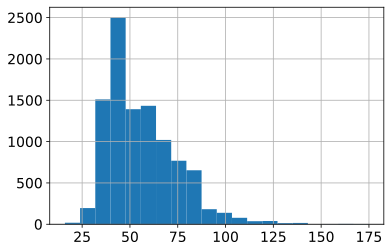

In [16]:
train_predata['Square'].hist(bins=20)

# Распределение целевой переменной

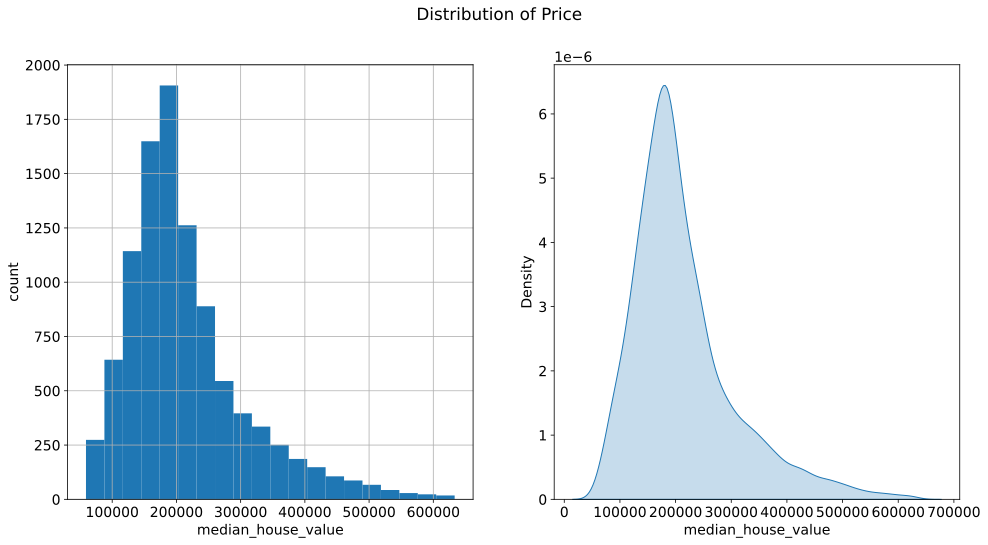

In [17]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_predata['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.subplot(122)
sns.kdeplot(train_predata['Price'], shade=True, legend=False)
plt.xlabel('median_house_value')

plt.suptitle('Distribution of Price')
plt.show()

# Матрица корреляций

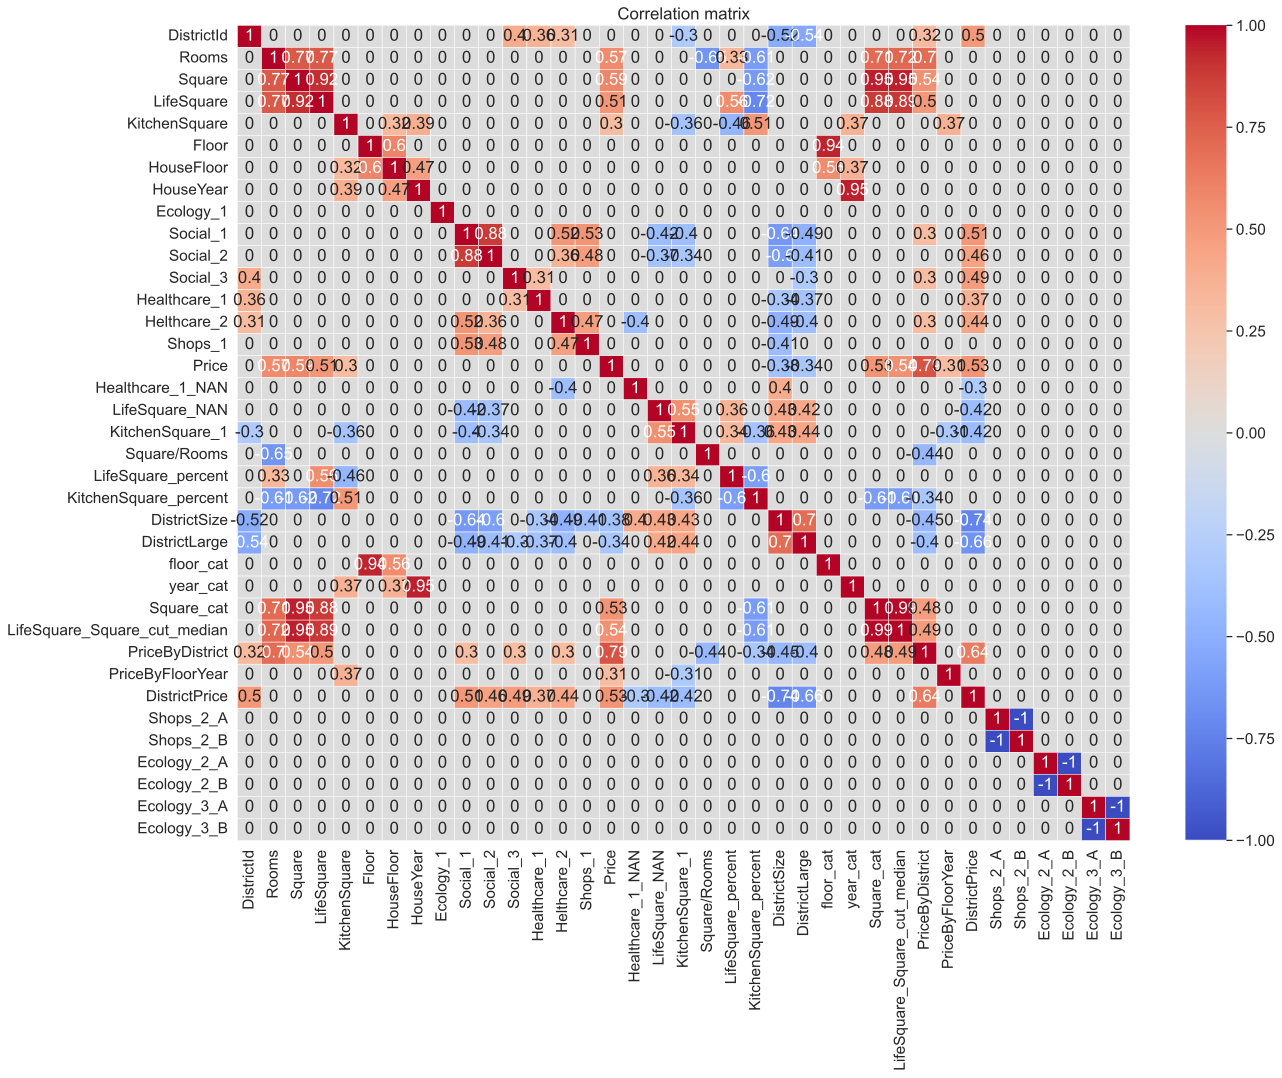

In [18]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)

corr_matrix = train_predata.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# Нормализация и разбиение тренировочных данных на x_train и x_valid

In [19]:
scaler = RobustScaler()

In [20]:
features = train_predata.columns
features = features.drop('Price')

In [21]:
x = pd.DataFrame(train_predata, columns=features)

In [22]:
y = train_predata['Price']

In [23]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=False)

In [24]:
features_scale = [
    feature
    for feature, weight in zip(x_train.columns, x_train.describe()[7:].max())
    if weight > 1
]

In [25]:
x_train[features_scale] = scaler.fit_transform(x_train[features_scale])

In [26]:
x_valid[features_scale] = scaler.transform(x_valid[features_scale])

# График разброса реальных и предсказанных цен

In [27]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(15,15))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

# Построение XGBR model - модель градиентного бустинга

R2:	0.79
RMSE:	41558.336
MSE:	1727095400.0


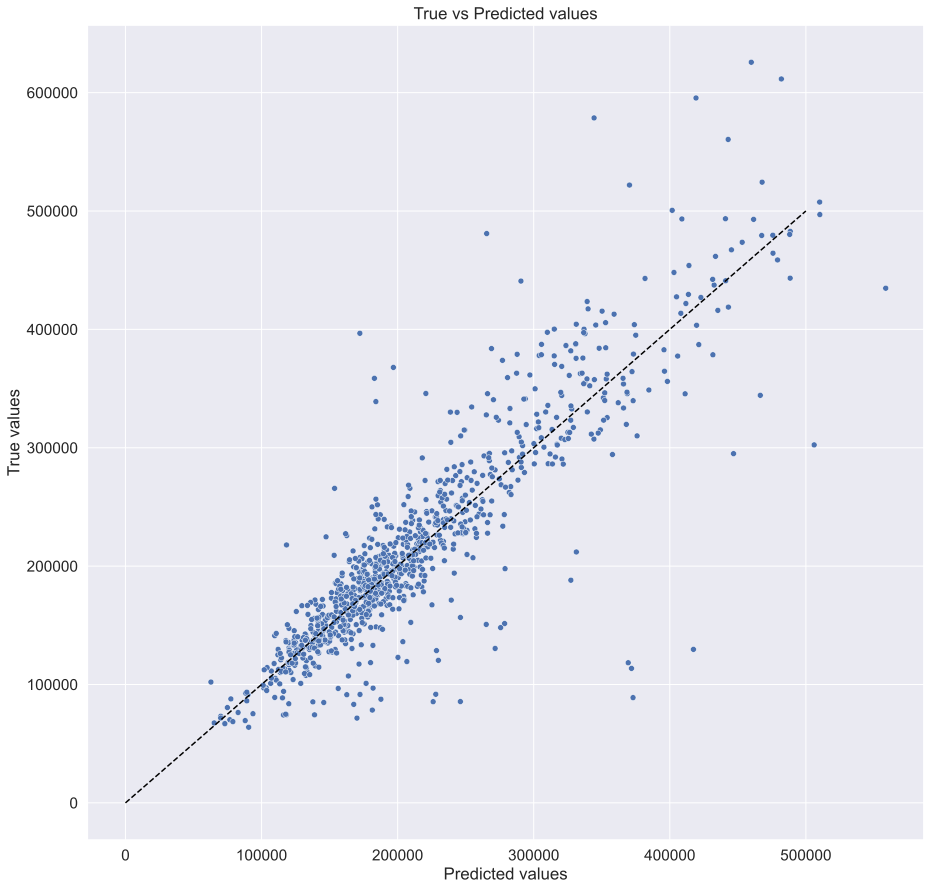

In [28]:
gb_model = xgb.XGBRegressor(colsample_bytree=0.4445, 
                             learning_rate=0.015, max_depth=6,
                             min_child_weight=0.1, 
                             n_estimators=1000,
                             reg_lambda=0.6,   
                             random_state =7)
gb_model.fit(x_train, y_train)

y_pred = gb_model.predict(x_valid)

evaluate_preds(y_valid, y_pred)

# Важность признаков

In [29]:
feature_importances = pd.DataFrame(zip(x_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
22,DistrictLarge,0.180794
27,PriceByDistrict,0.149607
26,LifeSquare_Square_cut_median,0.097211
1,Rooms,0.076956
25,Square_cat,0.063805
29,DistrictPrice,0.053830
2,Square,0.051117
21,DistrictSize,0.048091
11,Social_3,0.024343
10,Social_2,0.021920


# Работа с тестовыми данными

In [30]:
test_predata = dp.transform_test(test_predata)

In [31]:
test_predata = reduce_mem_usage(test_predata)

Memory usage of dataframe is 1.16 MB
Memory usage after optimization is: 0.53 MB
Decreased by 54.3%


In [32]:
features = test_predata.columns

In [33]:
x_test = pd.DataFrame(test_predata, columns=features)

In [34]:
x_test[features_scale] = scaler.transform(x_test[features_scale])

In [35]:
x_test.shape, x_train.shape

((5000, 36), (9000, 36))

In [36]:
y_pred = gb_model.predict(x_test)

In [37]:
df1['Price'] = y_pred

In [38]:
df1.to_csv('submit.csv', index=False)